In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

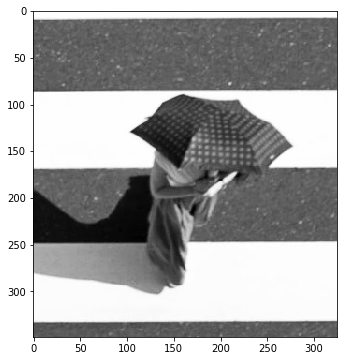

In [71]:
img = cv2.imread('umbrella.jpg',0)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img,'gray')

In [72]:
diff_i = 100
img2 = np.zeros(img.shape,dtype=int)
for i in range(img2.shape[0]):
    for j in range(img2.shape[1]):
        n_i = i - diff_i
        if(n_i < 0) or (n_i > img2.shape[0]-1):
            img2[i,j] = 0
#         if(n_j < 0) or (n_j > img2.shape[1]-1):
#             img2[i,j] = 0
        else:
            img2[i,j] = img[n_i,j]

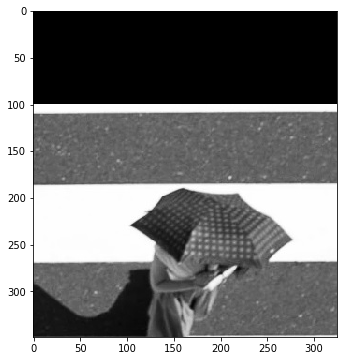

In [73]:
plt.imshow(img2,'gray')

In [74]:
diff_j = 100
img3 = np.zeros(img.shape,dtype=int)
for i in range(img3.shape[0]):
    for j in range(img3.shape[1]):
        n_j = j - diff_j
        if(n_j < 0) or (n_j > img2.shape[1]-1):
            img2[i,j] = 0
        else:
            img3[i,j] = img2[i,n_j]

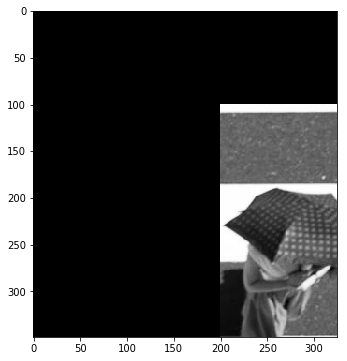

In [75]:
plt.imshow(img3,'gray')

In [128]:
img4 = np.zeros((img.shape[0],img.shape[1],2))
img4[:,:,0] = img
img4[:,:,1] = np.full((img.shape[0],img.shape[1]),1)

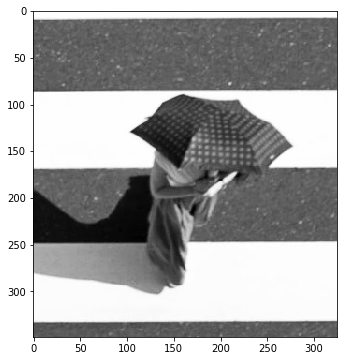

In [131]:
plt.imshow(img4[:,:,0],'gray')

In [132]:
img4[:,:,1]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [136]:
mat = np.array([[1,0,diff_i],[0,1,diff_j],[0,0,1]])

In [137]:
mat

array([[  1,   0, 100],
       [  0,   1, 100],
       [  0,   0,   1]])

In [169]:
i_index = np.zeros(img.shape)
j_index = np.zeros(img.shape)

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        i_index[i,j] = i
        j_index[i,j] = j
        
index_mat = np.zeros((img.shape[0],img.shape[1],3))
index_mat[:,:,0] = i_index
index_mat[:,:,1] = j_index
index_mat[:,:,2] = np.full(img.shape,1)
index_mat = np.reshape(index_mat,(img.shape[0]*img.shape[1],3))

In [318]:
dx = -50
dy = 20
theta = 45
trans_mat = np.array([[1,0,0],[0,1,0],[-dy,-dx,1]])
rot_mat = np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]])

In [322]:
def translateImg(img,dx,dy):
    trans_mat = np.array([[1,0,0],[0,1,0],[-dy,-dx,1]])
    trans_index = np.reshape(index_mat.dot(trans_mat),(img.shape[0],img.shape[1],3)).astype('int')
    trans_img = np.zeros(img.shape,dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            n_i = trans_index[i,j,0]
            n_j = trans_index[i,j,1]
            if(n_i < 0) or (n_i > img.shape[0]-1):
                trans_img[i,j] = 0
            elif(n_j < 0) or (n_j > img.shape[1]-1):
                trans_img[i,j] = 0
            else:
                trans_img[i,j] = img[n_i,n_j]
    return trans_img

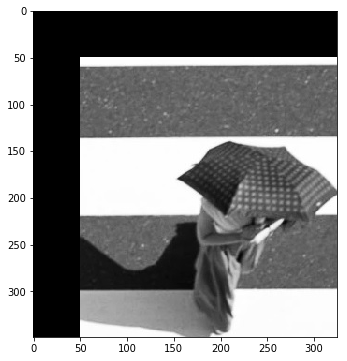

In [323]:
plt.imshow(translateImg(img,50,50),'gray')

In [335]:
def rotateImg(img,theta):
    theta = -theta
    rot_mat = np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]])
    rot_index = np.reshape(index_mat.dot(rot_mat),(img.shape[0],img.shape[1],3)).astype('int')
    rot_img = np.zeros(img.shape,dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rot_index[i,j] = rot_index[i,j]/rot_index[i,j,2] 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            n_i = rot_index[i,j,0]
            n_j = rot_index[i,j,1]
            if(n_i < 0) or (n_i > img.shape[0]-1):
                rot_img[i,j] = 0
            elif(n_j < 0) or (n_j > img.shape[1]-1):
                rot_img[i,j] = 0
            else:
                rot_img[i,j] = img[n_i,n_j]
    return rot_img

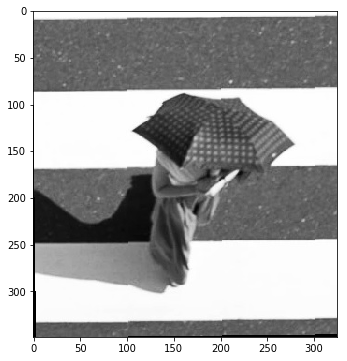

In [342]:
plt.imshow(rotateImg(img,0.01),'gray')

In [384]:
theta = 0.3
rot_mat = np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]])
rot_index = np.reshape(index_mat.dot(rot_mat),(img.shape[0],img.shape[1],3)).astype('int')
rot_img = np.zeros(img.shape,dtype=int)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        rot_index[i,j] = rot_index[i,j]/rot_index[i,j,2] 
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        n_i = rot_index[i,j,0]
        n_j = rot_index[i,j,1]
        if(n_i < 0) or (n_i > img.shape[0]-1):
            rot_img[i,j] = 0
        elif(n_j < 0) or (n_j > img.shape[1]-1):
            rot_img[i,j] = 0
        else:
            rot_img[i,j] = img[n_i,n_j]

In [408]:
i_index = np.zeros(img.shape)
j_index = np.zeros(img.shape)

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        i_index[i,j] = i
        j_index[i,j] = j
        
index_mat = np.zeros((img.shape[0],img.shape[1],3))
index_mat[:,:,0] = i_index
index_mat[:,:,1] = j_index
index_mat[:,:,2] = np.full(img.shape,1)
index_mat = np.reshape(index_mat,(img.shape[0]*img.shape[1],3))

In [437]:
theta = np.pi/4
w = img.shape[1]
h = img.shape[0]
rot_mat = np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]])
# rot_index = np.reshape(index_mat.dot(rot_mat),(img.shape[0],img.shape[1],3)).astype('int')
tl = np.array([[-h/2,-w/2,1]]).dot(rot_mat).astype(int)
tr = np.array([[-h/2,w/2,1]]).dot(rot_mat).astype(int)
bl = np.array([[h/2,-w/2,1]]).dot(rot_mat).astype(int)
br = np.array([[h/2,w/2,1]]).dot(rot_mat).astype(int)
nh = np.max([tl[0,0],tr[0,0],bl[0,0],br[0,0]])*2
nw = np.max([tl[0,1],tr[0,1],bl[0,1],br[0,1]])*2

In [435]:
(tl,tr,br,bl)

(array([[  -8, -238,    1]]),
 array([[-238,   -8,    1]]),
 array([[  8, 238,   1]]),
 array([[238,   8,   1]]))

In [436]:
(h,w,nh,nw)

(349, 325, 476, 476)

In [440]:
i_index = np.zeros((nh,nw))
j_index = np.zeros((nh,nw))

for i in range(nh):
    for j in range(nw):
        i_index[i,j] = i
        j_index[i,j] = j
        
index_mat = np.zeros((nh,nw,3))
index_mat[:,:,0] = i_index
index_mat[:,:,1] = j_index
index_mat[:,:,2] = np.full((nh,nw),1)
index_mat = np.reshape(index_mat,(nw*nh,3))

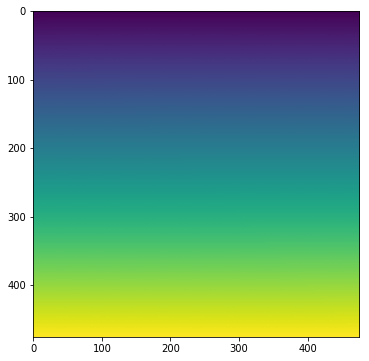

In [459]:
rotated_index_mat = index_mat.dot(rot_mat).astype(int)
rotated_index_mat = np.reshape(rotated_index_mat,(nh,nw,3))


plt.imshow(rotated_index_mat_reverse[:,:,0])

In [593]:
theta = np.pi/4
w = img.shape[1]
h = img.shape[0]
rot_mat = np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]])
tl = np.round(np.array([[-h/2,-w/2,1]]).dot(rot_mat)).astype(int)
tr = np.round(np.array([[-h/2,w/2,1]])).dot(rot_mat).astype(int)
bl = np.round(np.array([[h/2,-w/2,1]]).dot(rot_mat)).astype(int)
br = np.round(np.array([[h/2,w/2,1]]).dot(rot_mat)).astype(int)
nh = np.max([tl[0,0],tr[0,0],bl[0,0],br[0,0]])*2
nw = np.max([tl[0,1],tr[0,1],bl[0,1],br[0,1]])*2
rot_img = np.zeros((nh,nw),dtype=int)
for i in range(nh):
    for j in range(nw):
        pixel = np.array([i-int(nh/2),j-int(nw/2),1])
        pixel = pixel.dot(np.linalg.inv(rot_mat)).astype(int)
        if(pixel[0]+int(h/2) < 0) or (pixel[0]+int(h/2) > h-1):
            rot_img[i,j] = 0
        elif(pixel[1]+int(h/2) < 0) or (pixel[1]+int(w/2) > w-1):
            rot_img[i,j] = 0
        else:
            rot_img[i,j] = img[pixel[0]+int(h/2),pixel[1]+int(w/2)]

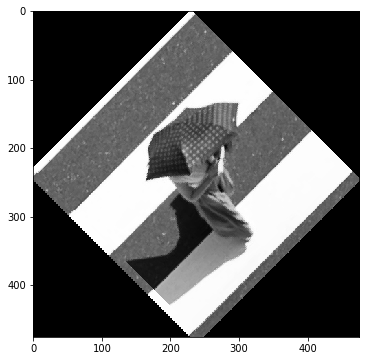

In [594]:
plt.imshow(rot_img,'gray')

In [595]:
(nw,nh)

(476, 476)

In [492]:
def f(i,j,h,w):
    rot_mat = np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]])
    tl = np.array([[-h/2,-w/2,1]]).dot(rot_mat).astype(int)
    tr = np.array([[-h/2,w/2,1]]).dot(rot_mat).astype(int)
    bl = np.array([[h/2,-w/2,1]]).dot(rot_mat).astype(int)
    br = np.array([[h/2,w/2,1]]).dot(rot_mat).astype(int)
    nh = np.max([tl[0,0],tr[0,0],bl[0,0],br[0,0]])*2
    nw = np.max([tl[0,1],tr[0,1],bl[0,1],br[0,1]])*2
    point = np.array([int(i-h/2),int(j-w/2),1])
    point = point.dot(rot_mat).astype(int)
    point[0] += int(nh/2)
    point[1] += int(nw/2)
    return point

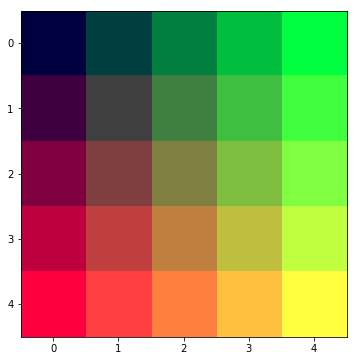

In [516]:
mat = np.array([[[0,0,1],[0,1,1],[0,2,1],[0,3,1],[0,4,1]],
                [[1,0,1],[1,1,1],[1,2,1],[1,3,1],[1,4,1]],
                [[2,0,1],[2,1,1],[2,2,1],[2,3,1],[2,4,1]],
                [[3,0,1],[3,1,1],[3,2,1],[3,3,1],[3,4,1]],
                [[4,0,1],[4,1,1],[4,2,1],[4,3,1],[4,4,1]]])
img_mat = np.zeros(mat.shape)
plt.imshow((mat/mat.max()))

In [518]:
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        mat[i,j] = f(i,j,mat.shape[0],mat.shape[1])

for i in range(img_mat.shape[0]):
    for j in range(img_mat.shape[1]):
        if(mat[i,j,0]<5)and(mat[i,j,1]<5):
            img_mat[i,j] = 1

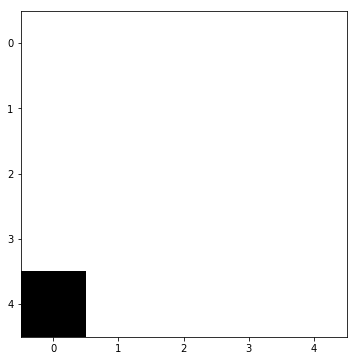

In [519]:
plt.imshow(img_mat)